In [1]:
## Import Python libraries ## 

import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import xarray as xr


%matplotlib inline
%reload_ext xsimlab.ipython


import fastscape

from orographic_precipitation.fastscape_ext import precip_model
from fastscape.processes import Bedrock

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.5.0
fastscape version:  0.1.0


In [3]:
## Build xarray-simlab model ##
SouthernAndesLEM = precip_model
SouthernAndesLEM = precip_model.drop_processes(['init_topography'])
SouthernAndesLEM = SouthernAndesLEM.update_processes({'bedrock': Bedrock})

SouthernAndesLEM

<xsimlab.Model (17 processes, 26 inputs)>
grid
    shape                  [in] ('shape_yx',) nb. of grid nodes in ...
    length                 [in] ('shape_yx',) total grid length in ...
boundary
    status                 [in] () or ('border',) node status at bo...
fs_context
uplift
    rate                   [in] () or ('y', 'x') uplift rate
tectonics
surf2erode
flow
orographic
    lapse_rate             [in] environmental lapse rate
    lapse_rate_m           [in] moist adiabatic lapse rate
    ref_density            [in] reference saturation water vapor de...
    latitude               [in] latitude
    precip_base            [in] () or ('y', 'x') background, non-or...
    rainfall_frequency  [inout] daily rainfall frequency
    wind_speed             [in] wind speed
    wind_dir               [in] wind direction (azimuth)
    conv_time              [in] conversion time
    fall_time              [in] fallout time
    nm                     [in] moist stability frequency
    hw  

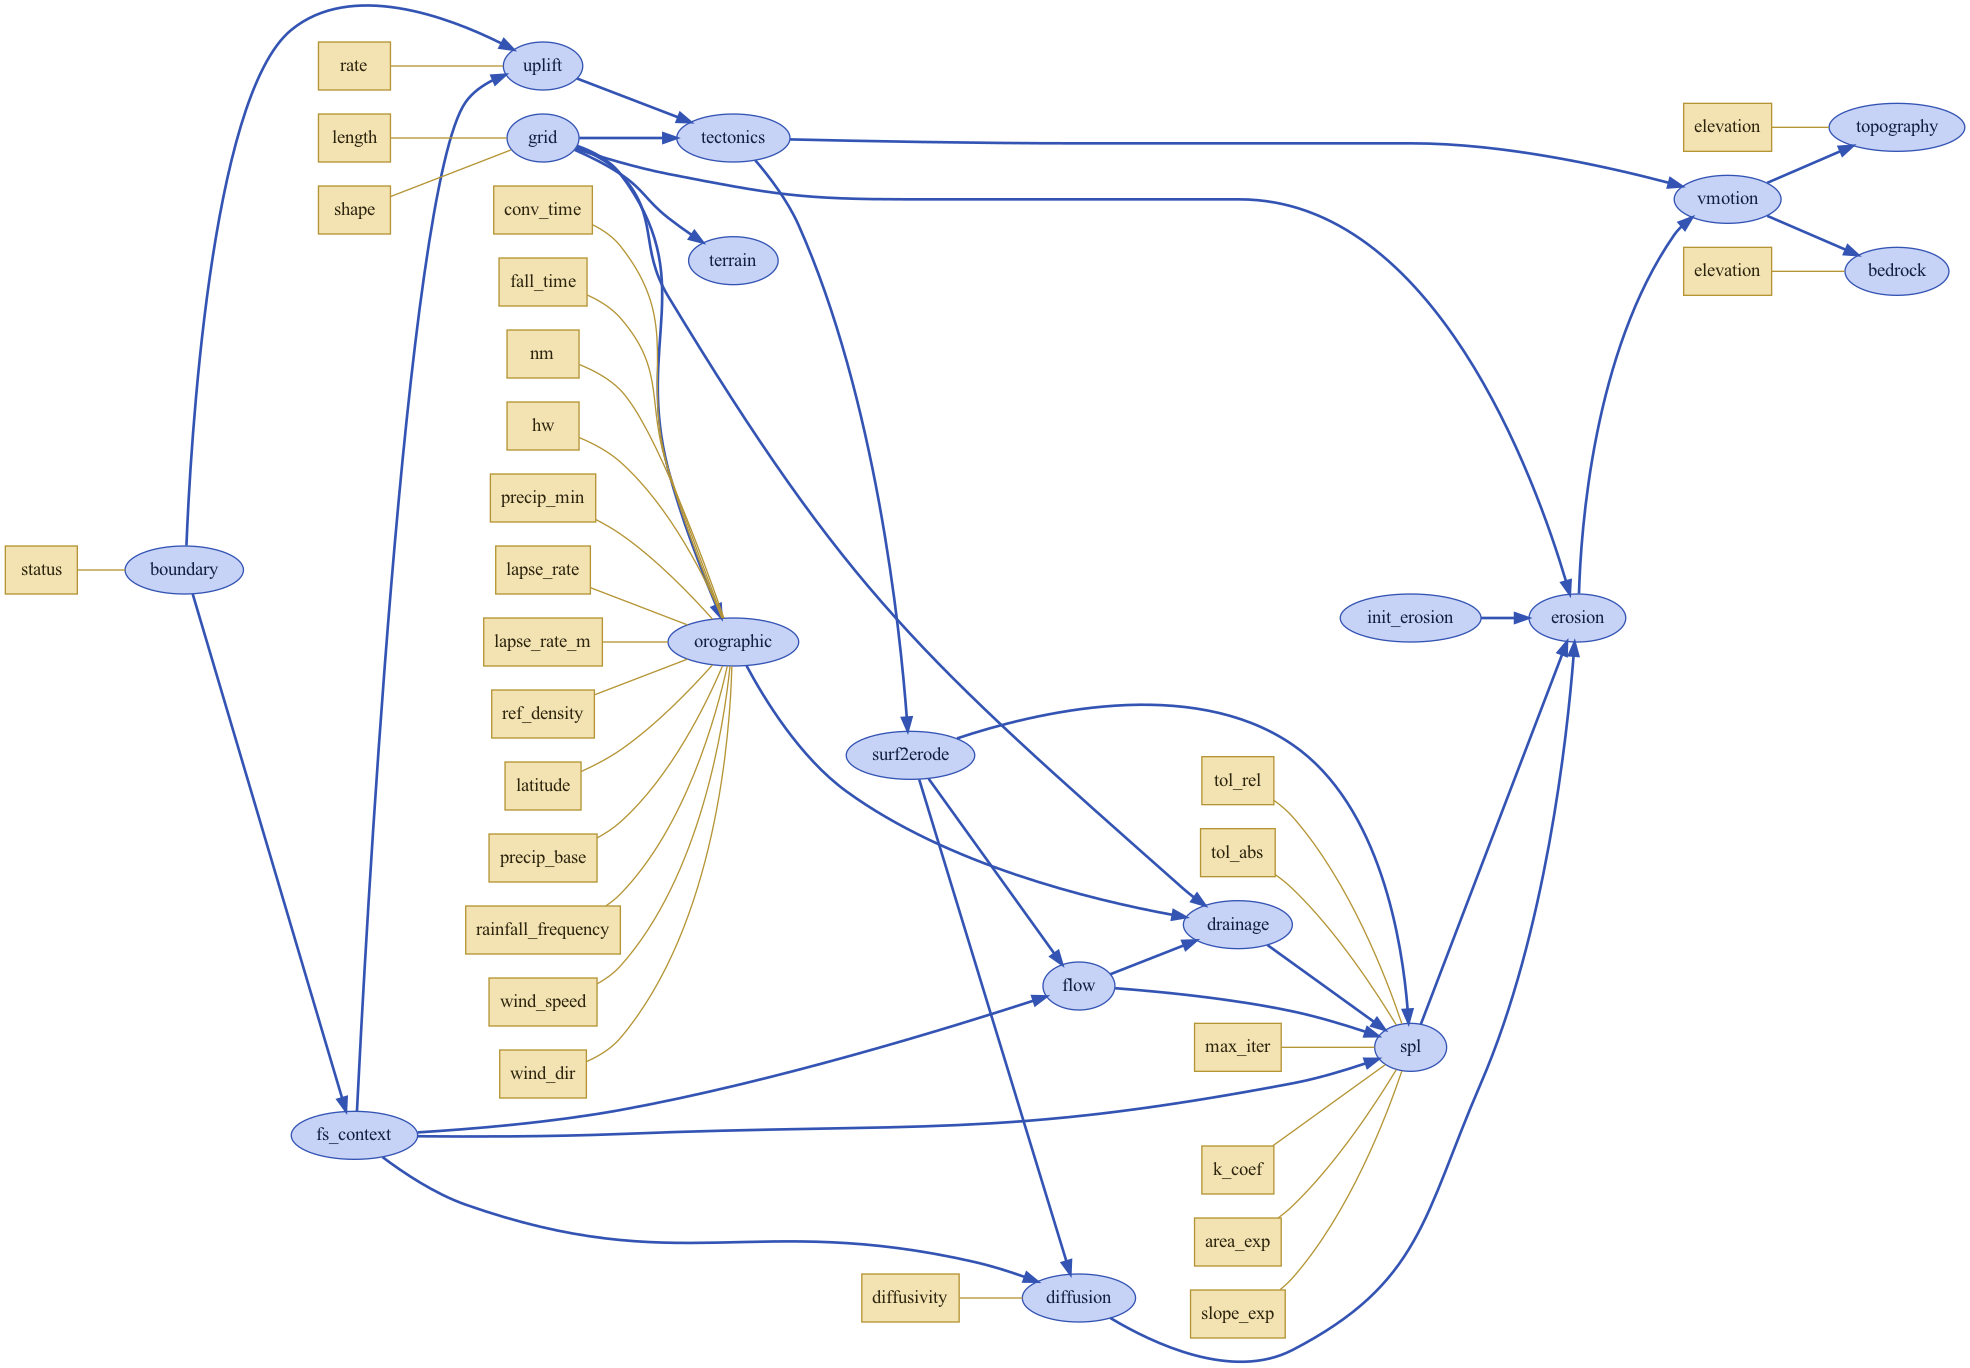

In [4]:
## Visualise xarray-simlab ##
SouthernAndesLEM.visualize(show_inputs='True')

In [5]:
## Model dimensions/grid dimensions ##
nx = 100
ny = 100
nn = nx * ny

xl = 100.e3
yl = 100.e3

BoundaryCondition = ['looped', 'looped', 'fixed_value', 'fixed_value']

## Model time and time stepping ##
EndTime_1 = 5e6
EndTime_2 = 5e6
EndTime_3 = 8e6
TimeSteps_1 = 10001
TimeSteps_2 = 10001
TimeSteps_3 = 16001

# EndTime = 1e6
# TimeSteps = 1001
ModelTime_1 = np.linspace(0., EndTime_1, TimeSteps_1)
ModelTime_2 = np.linspace(0., EndTime_2, TimeSteps_2)
ModelTime_3 = np.linspace(0., EndTime_3, TimeSteps_3)

PlotStep = 100

## Tectonics ##
k_coef= 2.5e-5
area_exp = 0.4
slope_exp = 1.0
diffusion_diffusivity = 0.


## Orographic ##
lapse_rate = -5.4 #mean lapse rate of area not too far away 
lapse_rate_m = -6.5 #left default
ref_density = 7.4e-3  #left default
rainfall_frequency = 5 #could not find high resolution data for hourly rainfall in the area of patagonia i was interested in looking at so just an estimate
latitude = 46  #latitude around the area north in the Patagonian Andes
precip_base =  1e-4 #not sure if I should change this or not
wind_speed = 10 #base to start with 
wind_dir = 270  # estimated direction given weather info 
precip_min = 0.1 #default
conv_time = 2000 #2000 thesis value
fall_time = 2000 #2000 thesis value
nm = 0.003  #0.03 #thesis value
hw = 5000  #default


## Initial topography ##
WhiteNoiseLevel = 50 # in [m], amplitude of noise

## Seed for Reproducibility ##
RandomSeed = 1410

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size
nx, ny = 100, 100  # Example values; adjust as needed
nn = nx * ny  # Total number of nodes

# Initialize an array to store elevations
InitialTopography = np.zeros(nn)

# Assign elevations based on node indices (using slicing and grid structure)
InitialTopography[:int(0.25 * nn)] = 400    # First 25% of nodes
InitialTopography[int(0.25 * nn):int(0.5 * nn)] = 3375  # Next 25% of nodes
InitialTopography[int(0.5 * nn):int(0.75 * nn)] = 2500  # Next 25% of nodes
InitialTopography[int(0.75 * nn):] = 1000  # Last 25% of nodes

# Adding random noise to the elevations
np.random.seed(42)  # For reproducibility
WhiteNoiseLevel = 50  # Standard deviation of noise
Noise = np.random.normal(0, WhiteNoiseLevel, nn)
InitialTopography += Noise  # Add noise to the elevations

# Reshape the 1D array to 2D with shape (ny, nx)
InitialTopography_2D = InitialTopography.reshape((ny, nx))

# Define first stage uplift rates for each region
UpliftRates = np.zeros(nn)  # Initialize uplift rates array

# Assign uplift rates to regions (using slicing or fractions of the total nodes)
UpliftRates[:int(0.25 * nn)] = 0.01    # First 25% of nodes
UpliftRates[int(0.25 * nn):int(0.5 * nn)] = 0.041  # Next 25% of nodes
UpliftRates[int(0.5 * nn):int(0.75 * nn)] = 0.035  # Next 25% of nodes
UpliftRates[int(0.75 * nn):] = 0.02  # Last 25% of nodes

# Adding random noise to the uplift rates for realism (optional)
np.random.seed(42)  # For reproducibility
UpliftNoise = np.random.normal(0, 0.005, nn)  # Small noise in uplift rates
UpliftRates += UpliftNoise  # Add noise to the uplift rates

# Reshape the 1D array to 2D with shape (ny, nx)
UpliftRates_2D = UpliftRates.reshape((ny, nx))

# Rotate both topography and uplift rates 90 degrees anti-clockwise
RotatedTopography_2D = np.rot90(InitialTopography_2D, k=1)
RotatedUpliftRates_2D = np.rot90(UpliftRates_2D, k=1)

In [7]:
import os
import numpy as np
import xsimlab as xs

# Directory to save Zarr files
output_dir = "simulation_outputs"
os.makedirs(output_dir, exist_ok=True)

# Define lapse_rate_m values to test
lapse_rate_m_values = np.linspace(-6, -8, 10)  # Adjusted range from -6 to -8 with 10 steps

# Time steps to visualize
time_indices = [0, 1, 10, 100, 1000, 10000]
mean_elevations = []

# Loop through lapse_rate_m values and run simulations
for lapse_rate_m in lapse_rate_m_values:
    print(f"Running simulation for lapse_rate_m = {lapse_rate_m}")
    
    # Set up the model with the current lapse_rate_m
    in_ds_lapse = xs.create_setup(
        model=SouthernAndesLEM,
        clocks={
            'time': ModelTime_1,
            'output': ModelTime_1[::PlotStep]
        },
        master_clock='time',
        input_vars={
            'grid': {'shape': [nx, ny], 'length': [xl, yl]},
            'boundary': {'status': BoundaryCondition},
            'topography': {'elevation': RotatedTopography_2D},
            'bedrock': {'elevation': RotatedTopography_2D},
            'uplift': {'rate': RotatedUpliftRates_2D},
            'spl': {'k_coef': k_coef, 'area_exp': area_exp, 'slope_exp': slope_exp},
            'diffusion': {'diffusivity': diffusion_diffusivity},
            'orographic': {
                'lapse_rate': lapse_rate,
                'lapse_rate_m': lapse_rate_m,  # Adjusted lapse_rate_m
                'ref_density': ref_density,
                'rainfall_frequency': rainfall_frequency,  # Keep rainfall_frequency
                'latitude': latitude,
                'precip_base': precip_base,
                'wind_speed': wind_speed,
                'wind_dir': wind_dir,
                'precip_min': precip_min,
                'conv_time': conv_time,
                'fall_time': fall_time,
                'nm': nm,
                'hw': hw,
            },
        },
        output_vars={'topography__elevation': 'time', 'orographic__precip_rate': 'time'}
    )

    # Run the simulation
    with xs.monitoring.ProgressBar():
        out_ds_lapse = in_ds_lapse.xsimlab.run(model=SouthernAndesLEM)
    
    # Store simulation results in Zarr format
    zarr_filename = os.path.join(output_dir, f"simulation_lapse_rate_m_{lapse_rate_m:.2f}.zarr")
    out_ds_lapse.to_zarr(zarr_filename, mode='w')
    print(f"Saved results for lapse_rate_m = {lapse_rate_m} to {zarr_filename}")

Running simulation for lapse_rate_m = -6.0


             0% | initialize 

Saved results for lapse_rate_m = -6.0 to simulation_outputs/simulation_lapse_rate_m_-6.00.zarr
Running simulation for lapse_rate_m = -6.222222222222222


             0% | initialize 

Saved results for lapse_rate_m = -6.222222222222222 to simulation_outputs/simulation_lapse_rate_m_-6.22.zarr
Running simulation for lapse_rate_m = -6.444444444444445


             0% | initialize 

Saved results for lapse_rate_m = -6.444444444444445 to simulation_outputs/simulation_lapse_rate_m_-6.44.zarr
Running simulation for lapse_rate_m = -6.666666666666667


             0% | initialize 

Saved results for lapse_rate_m = -6.666666666666667 to simulation_outputs/simulation_lapse_rate_m_-6.67.zarr
Running simulation for lapse_rate_m = -6.888888888888889


             0% | initialize 

Saved results for lapse_rate_m = -6.888888888888889 to simulation_outputs/simulation_lapse_rate_m_-6.89.zarr
Running simulation for lapse_rate_m = -7.111111111111111


             0% | initialize 

Saved results for lapse_rate_m = -7.111111111111111 to simulation_outputs/simulation_lapse_rate_m_-7.11.zarr
Running simulation for lapse_rate_m = -7.333333333333333


             0% | initialize 

Saved results for lapse_rate_m = -7.333333333333333 to simulation_outputs/simulation_lapse_rate_m_-7.33.zarr
Running simulation for lapse_rate_m = -7.555555555555555


             0% | initialize 

Saved results for lapse_rate_m = -7.555555555555555 to simulation_outputs/simulation_lapse_rate_m_-7.56.zarr
Running simulation for lapse_rate_m = -7.777777777777778


             0% | initialize 

Saved results for lapse_rate_m = -7.777777777777778 to simulation_outputs/simulation_lapse_rate_m_-7.78.zarr
Running simulation for lapse_rate_m = -8.0


             0% | initialize 

Saved results for lapse_rate_m = -8.0 to simulation_outputs/simulation_lapse_rate_m_-8.00.zarr


Available lapse_rate_m values in dataset: [-8.   -7.78 -7.56 -7.33 -7.11 -6.89 -6.67 -6.44 -6.22 -6.  ]


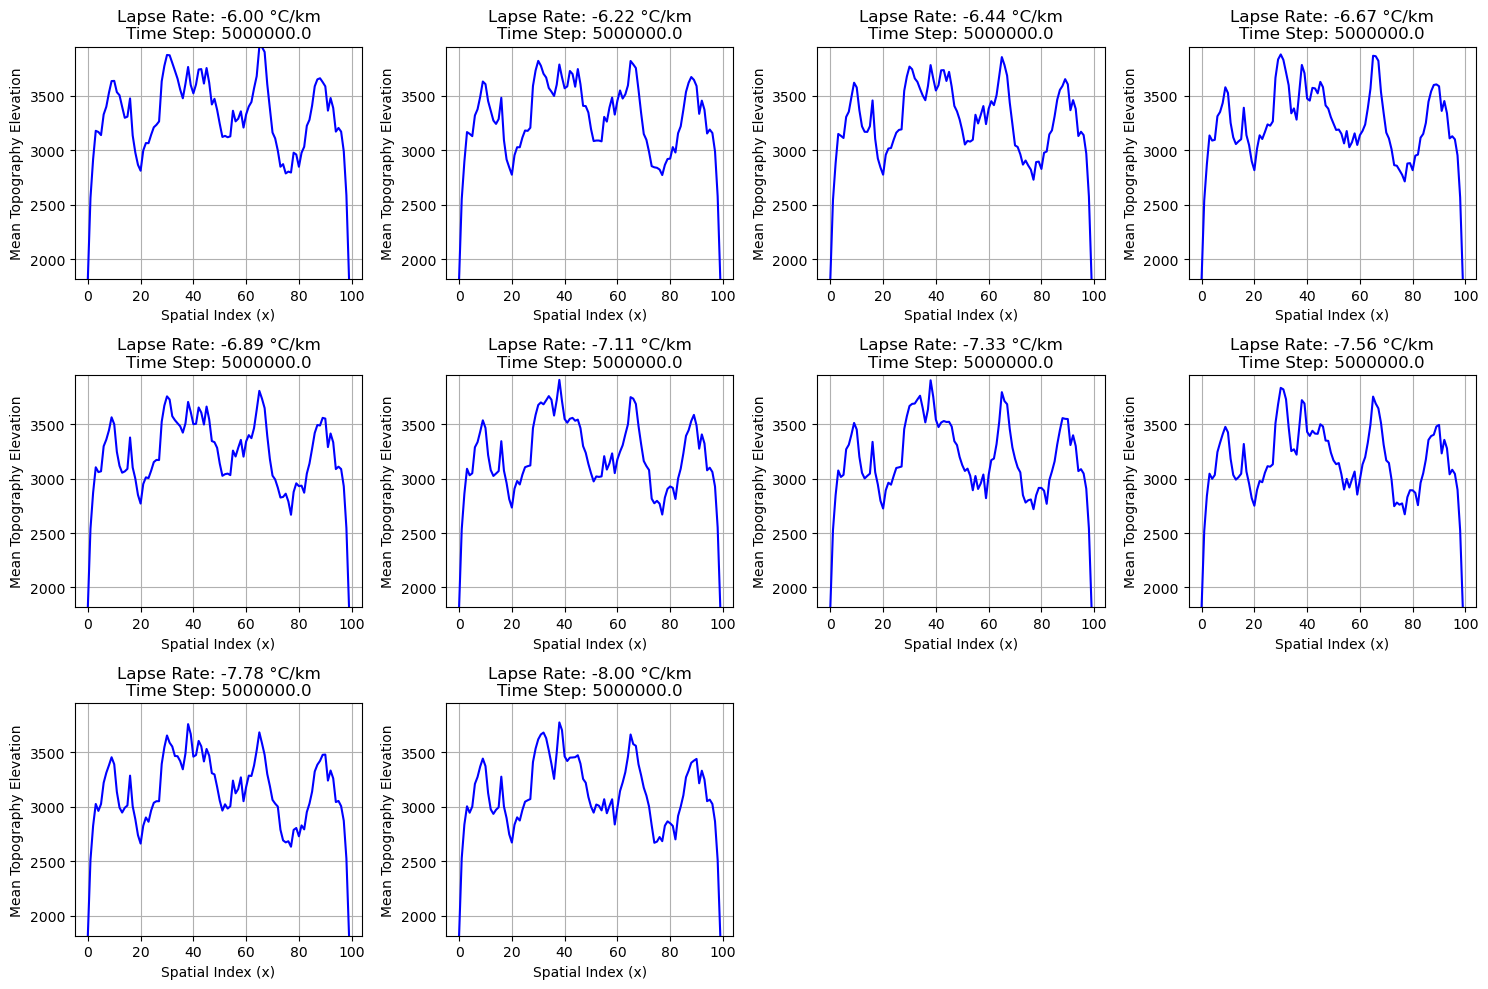

In [9]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by lapse_rate_m values
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_lapse_rate_m_") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract and sort lapse_rate_m values

# Define the lapse_rate_m values to plot
desired_lapse_rates = np.linspace(-6, -8, 10)  # Ensure it matches simulation values

# Load datasets and attach lapse_rate_m as a coordinate
datasets = []
lapse_rates = []

for zarr_file in zarr_files:
    lapse_rate_m = float(zarr_file.split("_")[-1][:-5])  # Extract lapse_rate_m from filename
    ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
    
    # Add lapse_rate_m as a coordinate
    ds = ds.assign_coords(lapse_rate_m=lapse_rate_m)
    
    datasets.append(ds)
    lapse_rates.append(lapse_rate_m)

# Concatenate datasets along the new lapse_rate_m dimension
combined_ds = xr.concat(datasets, dim="lapse_rate_m")

# Ensure lapse_rate_m is a dimension and coordinate
combined_ds = combined_ds.sortby("lapse_rate_m")

# Print available values for debugging
print("Available lapse_rate_m values in dataset:", combined_ds.lapse_rate_m.values)

# Fix: Use nearest selection for valid lapse_rate_m values
valid_lapse_rates = []
for lr in desired_lapse_rates:
    try:
        elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lr, method="nearest").mean(dim='x')
        valid_lapse_rates.append(lr)
    except KeyError:
        print(f"Skipping {lr}: No matching data found.")

# Adjust number of rows and columns based on valid lapse_rate_m values
n_valid = len(valid_lapse_rates)
ncols = 4  # Define number of columns
nrows = (n_valid // ncols) + (1 if n_valid % ncols != 0 else 0)  # Calculate rows needed

# Create subplots dynamically based on valid lapse_rate_m values
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axes = axes.flatten()

# Initialize variables to track global min and max for consistent y-axis scaling
global_min_elevation = np.inf
global_max_elevation = -np.inf

# First, loop to find the global min and max of the mean topography elevations
for lr in valid_lapse_rates:
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lr, method="nearest").mean(dim='x')
    global_min_elevation = min(global_min_elevation, elevation_data.min())
    global_max_elevation = max(global_max_elevation, elevation_data.max())

# Plot only for valid lapse_rate_m values
for idx, lr in enumerate(valid_lapse_rates):
    ax = axes[idx]
    time_step = str(combined_ds.time[-1].values)  # Extract the last time step value
    title = f"Lapse Rate: {lr:.2f} °C/km\nTime Step: {time_step}"
    
    # Get the mean elevation for this lapse_rate_m at the last time step
    elevation_data = combined_ds.topography__elevation.isel(time=-1).sel(lapse_rate_m=lr, method="nearest").mean(dim='x')
    
    # Plot the elevation data as a line plot
    ax.plot(elevation_data, label='Mean Topography Elevation', color='blue')
    
    ax.set_title(title)
    ax.set_ylabel("Mean Topography Elevation")
    ax.set_xlabel("Spatial Index (x)")
    ax.set_ylim(global_min_elevation, global_max_elevation)
    ax.grid(True)

# Hide unused axes
for ax in axes[len(valid_lapse_rates):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


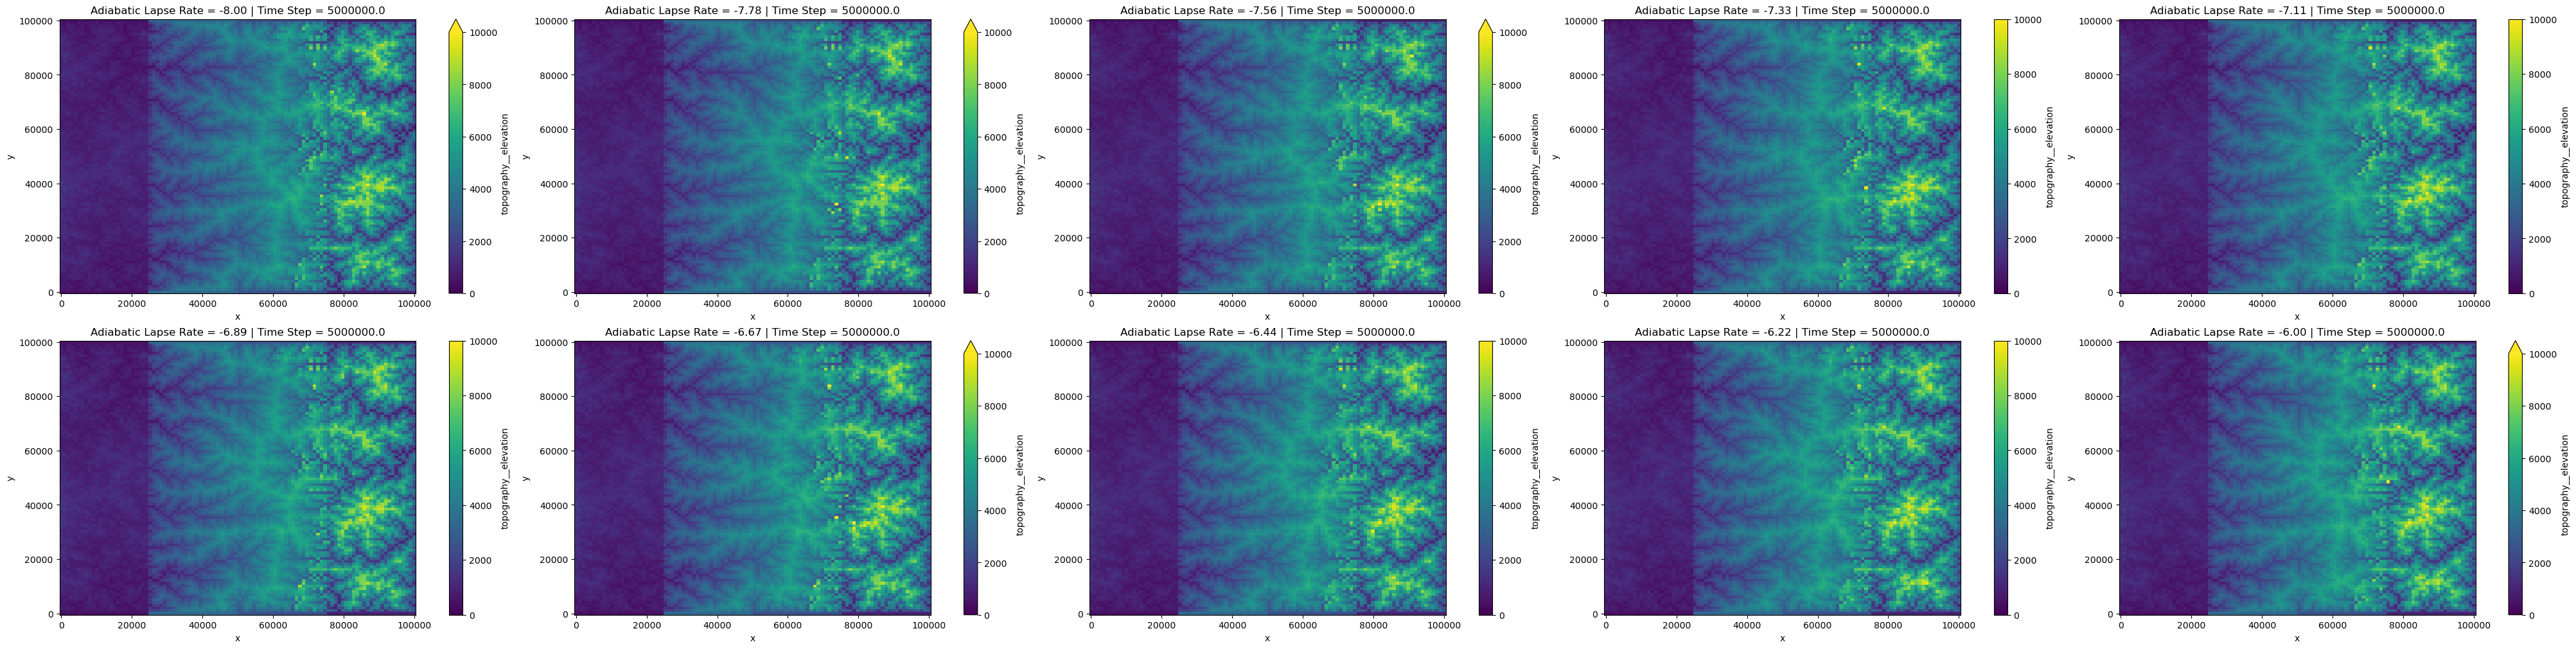

In [11]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by lapse_rate_m
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_lapse_rate_m") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract lapse_rate_m from filename

# Define specific lapse_rate_m values to plot
desired_lapse_rates = [-8., -7.78, -7.56, -7.33, -7.11, -6.89, -6.67, -6.44, -6.22, -6.]  # Adjust based on your simulations

# Load datasets and attach lapse_rate_m as a coordinate
datasets = []
lapse_rates = []
time_steps = []

for zarr_file in zarr_files:
    lapse_rate_m = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if lapse_rate_m in desired_lapse_rates:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add lapse_rate_m as a coordinate
        ds = ds.assign_coords(lapse_rate_m=lapse_rate_m)
        
        datasets.append(ds)
        lapse_rates.append(lapse_rate_m)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

# Concatenate datasets along the new lapse_rate_m dimension
combined_ds = xr.concat(datasets, dim="lapse_rate_m")
combined_ds = combined_ds.sortby("lapse_rate_m")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(lapse_rates)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Elevation Maps for Selected Lapse Rates at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, lapse_rate_m, time_step in zip(axes, datasets, lapse_rates, time_steps):
    ds.topography__elevation.isel(time=-1).plot(ax=ax, vmin=0, vmax=10000, cmap='viridis')
    ax.set_title(f"Adiabatic Lapse Rate = {lapse_rate_m:.2f} | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Hide any unused subplots
for i in range(len(lapse_rates), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Elevation_LapseRateM_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()


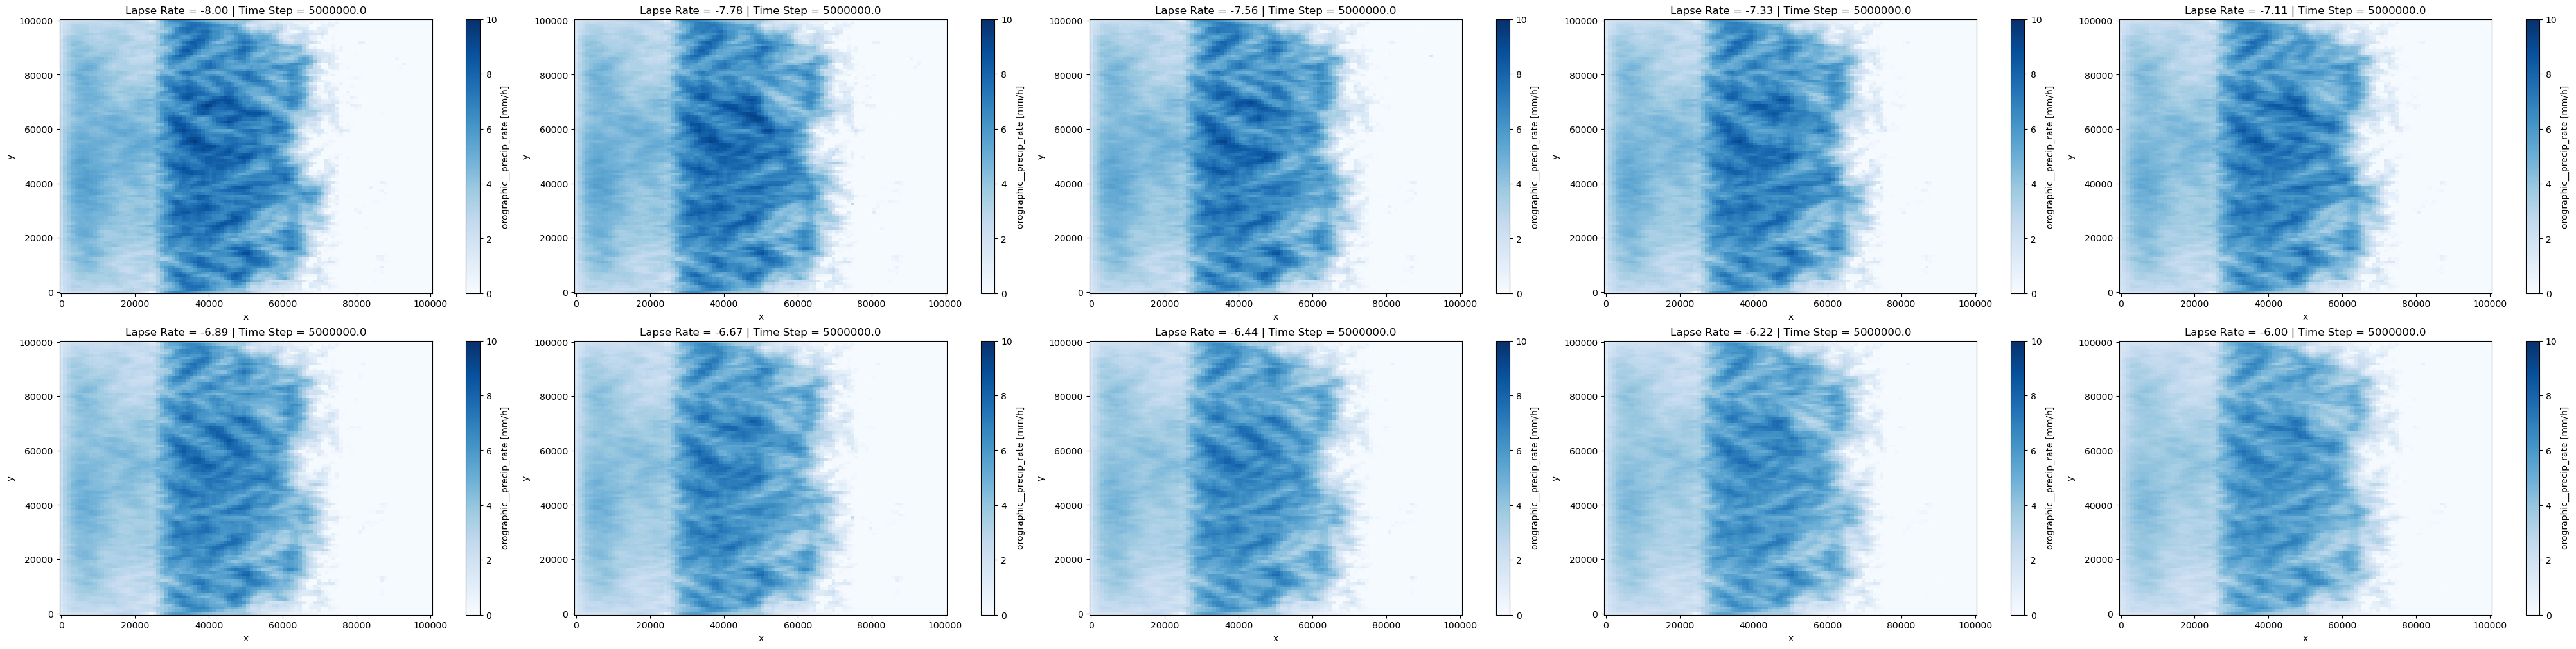

In [13]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Directory containing Zarr files
output_dir = "simulation_outputs"

# List all Zarr files and sort by lapse_rate_m values
zarr_files = [f for f in os.listdir(output_dir) if f.startswith("simulation_lapse_rate_m") and f.endswith(".zarr")]
zarr_files.sort(key=lambda f: float(f.split("_")[-1][:-5]))  # Extract lapse_rate_m values

# Define specific lapse_rate_m values to plot
desired_lapse_rates = [-8., -7.78, -7.56, -7.33, -7.11, -6.89, -6.67, -6.44, -6.22, -6.]   # Adjust based on your simulations

# Load datasets and attach lapse_rate_m as a coordinate
datasets = []
lapse_rates = []
time_steps = []

for zarr_file in zarr_files:
    lapse_rate_m = float(zarr_file.split("_")[-1][:-5])  # Extract value
    if lapse_rate_m in desired_lapse_rates:  # Only include selected values
        ds = xr.open_zarr(os.path.join(output_dir, zarr_file), chunks={})
        
        # Add lapse_rate_m as a coordinate
        ds = ds.assign_coords(lapse_rate_m=lapse_rate_m)
        
        datasets.append(ds)
        lapse_rates.append(lapse_rate_m)  # Append only desired values
        
        # Extract the last time step
        time_steps.append(ds.time.values[-1])

# Concatenate datasets along the new lapse_rate_m dimension
combined_ds = xr.concat(datasets, dim="lapse_rate_m")
combined_ds = combined_ds.sortby("lapse_rate_m")  # Ensure correct order

# Calculate grid layout for subplots
num_plots = len(lapse_rates)
num_cols = (num_plots + 1) // 2  
num_rows = (num_plots + num_cols - 1) // num_cols  

# 📌 Plot: Precipitation Maps for Selected Lapse Rate Values at Final Time Step
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 10), constrained_layout=True)
axes = axes.flatten()

# Loop over datasets and create plots
for ax, ds, lapse_rate_m, time_step in zip(axes, datasets, lapse_rates, time_steps):
    # Plot precipitation at the final time step
    precip_data = ds.orographic__precip_rate.isel(time=-1)
    precip_data.plot(ax=ax, vmin=0, vmax=10, cmap='Blues')
    ax.set_title(f"Lapse Rate = {lapse_rate_m:.2f} | Time Step = {time_step}", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Hide any unused subplots
for i in range(len(lapse_rates), len(axes)):
    fig.delaxes(axes[i])

plt.savefig("Precipitation_LapseRate_Selected.png")
plt.show()

# Close all datasets
for ds in datasets:
    ds.close()
